# Titanic Survival Prediction: Exploratory Data Analysis
~ "Extracting Signals from Chaos"

## Objective
While this is a classic ML competition, I approach it with a trader's mindset:
- Treat survival probability as a binary classification problem (like trade success/failure).
- Identify high-impact features (e.g., socioeconomic status ≈ market participant tiers).
- Uncover non-linear relationships (e.g., age vs. survival resembling option payoff curves).

## Key Questions
1. Feature Engineering:
    - Does Fare behave like a "price" with survival probability as its delta?
    - Can Name titles (Mr./Mrs.) proxy for behavioral biases in crisis?
2. Risk Factors:
    - How does Pclass interact with Age like a portfolio’s risk layers?
    - Are missing values in Cabin analogous to incomplete market data?
3. Modeling Implications:
    - Should we treat SibSp/Parch as correlated assets?
    - Does Embarked show geographic clusters like regional liquidity?

## Methodology
1. Survival Rates by Group: Calculated like a trading strategy’s win rate.
2. Visualizations:
    - Heatmaps for feature correlations (≈ cross-asset dependencies).
    - Kernel density plots for Age/Fare (≈ fat-tailed distributions).
3. Statistical Tests:
    - Chi-square for categorical independence (e.g., Sex vs. survival).
    - Kolmogorov-Smirnov to compare distributions (e.g., Fare by class).

## Tools
```
import pandas as pd  # Data as a "price series"
import seaborn as sns  # Visualizing "market structure"
from scipy import stats  # Quantifying feature significance
```

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [6]:
# Load the raw Titanic datasets
train_data = pd.read_csv('../data/raw/train.csv')
test_data = pd.read_csv('../data/raw/test.csv')

In [7]:
print("Train Data:")
print(train_data.head())
print(train_data.tail())

Train Data:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN  

In [22]:
print("Train Data Info:")
print(train_data.info())

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [ ]:
print("Train Data Described:")
print(train_data.describe())

It seems the training data is missing data from Age, Cabin and Embarked that we have to deal with later. Of all the columns, PassengerId and Name is not really important factors to the prediction, while Survived is the response variable and {pclass, age, sex, sibsp, parch, ticket number, fare, cabin, embarked} are all input variables, with ticket number, fare and cabin being factors seemingly more disconnected to the survival rate.

In [8]:
#checking mode 
train_data.mode().iloc[0]

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

From the training data, the mode for categories Age, Cabin, and Embarked are 24.0, B96 B98, and S respectively. #bro the cabin got too much missing values idt the mode is accurate for cabin, the rest looks okay so far...

In [ ]:
# Make new dataset with edited data
df_processed = train_data.copy()
df_processed["Embarked"] = df_processed["Embarked"].fillna(df_processed["Embarked"].mode()[0])
df_processed = df_processed.drop(columns=["Cabin"])
df_processed = df_processed.dropna(subset=["Age"])

# View processed train data
print("Processed Train Data:")
print(df_processed.head())
print(df_processed.tail())

print("Processed Train Data Info:")
print(df_processed.info())


Processed Train Data:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Embarked  
0      0         A/5 21171   7.2500        S  
1      0          PC 17599  71.2833        C  
2      0  STON/O2. 3101282   7.9250        S  
3      0            113803  53.1000        S  
4      0            373450   8.0500        S  
     PassengerId

In [25]:
# postive cases
num_survived = df_processed["Survived"].sum()
print("postitive cases:" + str(num_survived))

# total cases
total = df_processed["Survived"].count()

# survival rate
percentage = (num_survived / total) * 100
print(f"Survived: {num_survived} / {total} ({percentage:.2f}%)")

postitive cases:290
Survived: 290 / 714 (40.62%)


We see that after processing the data, there are 290 positive survival cases, meaning that out of 714 passengers, 290 of them survived, aka there is a 40.62% survival rate. This is a slight imbalance in the dataset. (we may need to see if the model is biased towards the majority class, which is survive == 0)

We separate the train set into categorical and quantitative variables. PassengerId was dropped as it was treated as the index and Ticket and Name and cabin was also dropped as from first glance the data was quite messy and hard to decipher (left to be analysed later Race????). Survived was the categorical (binary: 0,1) dependent variable, with the rest being independent variables. The categorical independent variables are {Pclass, Sex, SibSp, Parch, Embarked}, while the quantitative independent variables are {Age, Fare}.

In [19]:
categorical_variables = ['Pclass','Sex','SibSp','Parch','Embarked']
quantitative_variables = ['Age','Fare']
dependent_variable = ['Survived']

In [26]:
from scipy.stats import chi2_contingency
import pandas as pd

for cat_var in categorical_variables:
    # Create contingency table
    ct = pd.crosstab(train_data[cat_var], train_data['Survived'], margins=True)
    print(f"\n=== {cat_var} vs Survived ===")
    print(ct)
    
    # Chi-square test
    chi2, p, dof, expected = chi2_contingency(ct.iloc[:-1, :-1])  # Exclude margins
    print(f"\nChi-square test:\nχ²={chi2:.2f}, p={p:.4f}, df={dof}")
    
    # Calculate metrics based on table size
    if ct.shape == (3, 3):  # 2x2 table (excluding margins)
        # Odds Ratio
        oddsratio = (ct.iloc[0,0] * ct.iloc[1,1]) / (ct.iloc[0,1] * ct.iloc[1,0])
        print(f"\nOdds Ratio: {oddsratio:.2f}")
    else:
        # Conditional Probability (P(Survived=1 | Category))
        print("\nConditional Probabilities (P(Survived | Category)):")
        prob_df = pd.DataFrame({
            'Category': ct.index[:-1],
            'P(Survived=1)': ct.iloc[:-1, 1] / ct.iloc[:-1, 2]  # Survived / Total
        })
        print(prob_df.round(2))
    
    print("\n" + "-"*50)


=== Pclass vs Survived ===
Survived    0    1  All
Pclass                 
1          80  136  216
2          97   87  184
3         372  119  491
All       549  342  891

Chi-square test:
χ²=102.89, p=0.0000, df=2

Conditional Probabilities (P(Survived | Category)):
       Category  P(Survived=1)
Pclass                        
1             1           0.63
2             2           0.47
3             3           0.24

--------------------------------------------------

=== Sex vs Survived ===
Survived    0    1  All
Sex                    
female     81  233  314
male      468  109  577
All       549  342  891

Chi-square test:
χ²=260.72, p=0.0000, df=1

Odds Ratio: 0.08

--------------------------------------------------

=== SibSp vs Survived ===
Survived    0    1  All
SibSp                  
0         398  210  608
1          97  112  209
2          15   13   28
3          12    4   16
4          15    3   18
5           5    0    5
8           7    0    7
All       549  342  89

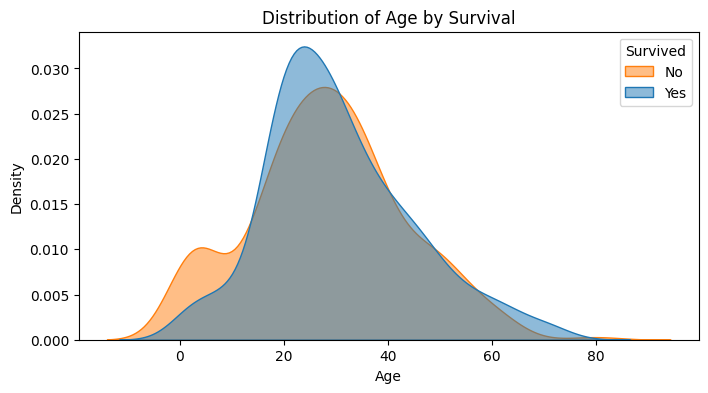

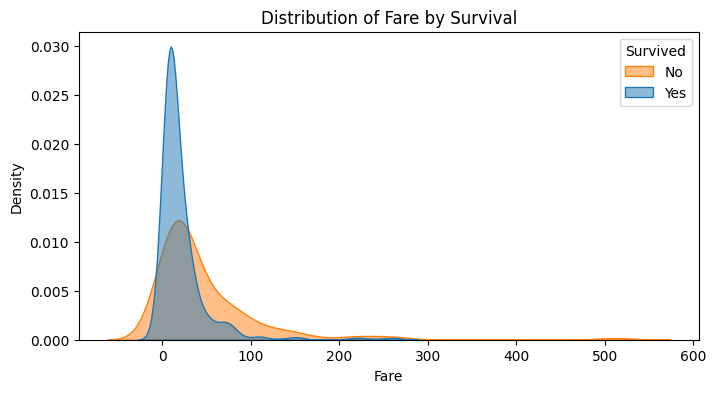

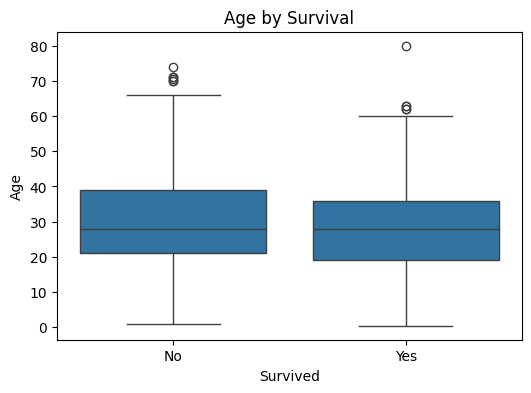

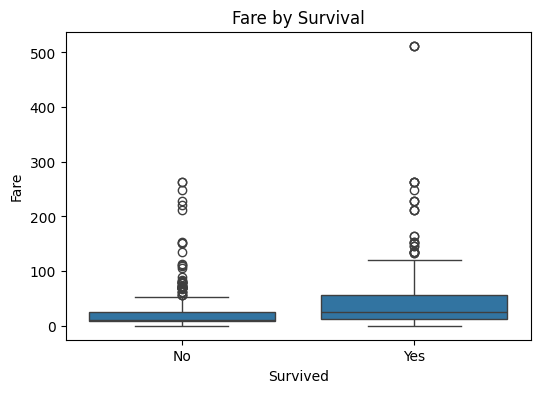

Age: Mann-Whitney U test p-value = 0.1605
Fare: Mann-Whitney U test p-value = 0.0000


In [27]:
# Plot distributions of quantitative variables by survival
for var in quantitative_variables:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=train_data, x=var, hue='Survived', common_norm=False, fill=True, alpha=0.5)
    plt.title(f'Distribution of {var} by Survival')
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.legend(title='Survived', labels=['No', 'Yes'])
    plt.show()

# Boxplots for quantitative variables by survival
for var in quantitative_variables:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=train_data, x='Survived', y=var)
    plt.title(f'{var} by Survival')
    plt.xlabel('Survived')
    plt.ylabel(var)
    plt.xticks([0, 1], ['No', 'Yes'])
    plt.show()

# Statistical test: Compare distributions (Mann-Whitney U test)
for var in quantitative_variables:
    survived = train_data[train_data['Survived'] == 1][var].dropna()
    not_survived = train_data[train_data['Survived'] == 0][var].dropna()
    stat, pval = stats.mannwhitneyu(survived, not_survived, alternative='two-sided')
    print(f"{var}: Mann-Whitney U test p-value = {pval:.4f}")

We see that the fare is right skewed, hence we will log the fare values

In [28]:
import numpy as np
df_processed["Fare"] = np.log(df_processed["Fare"] + 0.01)  # Adding 0.01 to avoid log(0)

In [ ]:
# Save cleaned data to CSV
df_processed.to_csv('../data/raw/train_processed.csv', index=False)